In [1]:
# https://colab.research.google.com/notebooks/mlcc/first_steps_with_tensor_flow.ipynb
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset as Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

In [2]:
# importing the dataset
california_housing_dataframe = pd.read_csv("D:/Users/Marco/Downloads/california_housing_train.csv", sep=",")

In [3]:
# Permutation of our dataset and make more readable the median_house_value
california_housing_dataframe = california_housing_dataframe.reindex(np.random.permutation(california_housing_dataframe.index))
california_housing_dataframe["median_house_value"] /= 1000.0
california_housing_dataframe

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
16205,-122.5,38.3,19.0,2398.0,521.0,1266.0,471.0,2.8,186.8
14195,-122.1,37.9,28.0,2377.0,469.0,1068.0,435.0,4.5,250.0
344,-116.9,33.9,34.0,3183.0,738.0,1820.0,647.0,2.2,71.8
13921,-122.0,37.4,34.0,2600.0,650.0,1994.0,650.0,4.0,250.2
11877,-121.3,38.1,32.0,1706.0,292.0,923.0,284.0,5.5,147.2
...,...,...,...,...,...,...,...,...,...
16021,-122.4,37.8,21.0,5457.0,1247.0,2304.0,1180.0,4.5,409.7
8781,-118.6,34.2,34.0,2633.0,471.0,1313.0,428.0,4.1,232.9
13222,-121.9,37.3,34.0,4613.0,749.0,2050.0,725.0,5.4,302.9
683,-117.0,34.0,28.0,3009.0,698.0,1200.0,626.0,1.4,104.6


In [4]:
california_housing_dataframe.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207.3
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,116.0
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,15.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119.4
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180.4
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500.0


In [5]:
targets = california_housing_dataframe["median_house_value"]
features = california_housing_dataframe[["total_rooms"]]

# 2 types of data for each feature: Numerical (number) and Categorical (textual) data
# In tensorflow we use feature_column to define the type of each feature data
# feature column contains only a description of the feature, not the data itself as it's shown below:
features_column = [tf.feature_column.numeric_column("total_rooms")]
# NumericColumn(key='total_rooms', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)

In [6]:
# We'll use GradientDescentOptimizer which implements a mini-batch Stochastic Gradiend Descent
# The learning_rate argument controls the size of the gradient step
optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.0000001)

# clip_gradients_by_norm applies a gradient clipping, which create an upperbound for the gradients
optimizer = tf.contrib.estimator.clip_gradients_by_norm(optimizer, clip_norm = 5.0)
# Configure model using Linear Regression model which uses LinearRegressor in tf
# Take in input NumericColumn (info of the features) and the optimizer (algorithm)
linear_regression = tf.estimator.LinearRegressor(
    features_column, 
    optimizer = optimizer)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [5]:
def input_fn(features, targets, batch_size = 1, shuffle = True, n_epochs = None):
    # Converts pandas to a dict of NumPy arrays
    features = {key: np.array(value) for key, value in dict(features).items()} 
    # Tensor_slices take tensor type in input (n, m) with n,m Natural. That is a vector/tuple  and return a dataset
    dataset = Dataset.from_tensor_slices((features, targets)).batch(batch_size).repeat(n_epochs)
    if shuffle:
        # buffer_size is the size of the dataset from which shuffle randomly shuffle
        dataset = dataset.shuffle(buffer_size = 10000)
    # Batch data
    return (dataset.make_one_shot_iterator().get_next())

In [ ]:
linear_regression.train(input_fn = lambda: input_fn(features, targets), steps= 1000)

In [ ]:
# Create an input function for predictions.
# Note: Since we're making just one prediction for each example, we don't 
# need to repeat or shuffle the data here.
prediction_input_fn = lambda: input_fn(features, targets, n_epochs=1, shuffle=False)

# Call predict() on the linear_regressor to make predictions.
predictions = linear_regression.predict(input_fn=prediction_input_fn)

# Format predictions as a NumPy array, so we can calculate error metrics.
predictions = np.array([item['predictions'][0] for item in predictions])

# Print Mean Squared Error and Root Mean Squared Error.
mean_squared_error = metrics.mean_squared_error(predictions, targets)
root_mean_squared_error = math.sqrt(mean_squared_error)
print("Mean Squared Error (on training data): %0.3f" % mean_squared_error)
print("Root Mean Squared Error (on training data): %0.3f" % root_mean_squared_error)

In [ ]:
'''
Mean Squared Error (MSE) can be hard to interpret, so we often look at Root Mean Squared Error (RMSE) instead. 
A nice property of RMSE is that it can be interpreted on the same scale as the original targets.
'''

min_house_value = california_housing_dataframe["median_house_value"].min()
max_house_value = california_housing_dataframe["median_house_value"].max()
min_max_difference = max_house_value - min_house_value

print("Min. Median House Value: %0.3f" % min_house_value)
print("Max. Median House Value: %0.3f" % max_house_value)
print("Difference between Min. and Max.: %0.3f" % min_max_difference)
print("Root Mean Squared Error: %0.3f" % root_mean_squared_error)

In [6]:
calibration_data = pd.DataFrame()
calibration_data["predictions"] = pd.Series(predictions)
calibration_data["targets"] = pd.Series(targets)
calibration_data["difference"] = calibration_data["predictions"] - calibration_data["targets"]
calibration_data.describe()

NameError: name 'predictions' is not defined

In [7]:
sample = california_housing_dataframe.sample(n=300)
sample.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0
mean,-119.5,35.6,27.1,2897.0,585.2,1554.0,538.8,3.8,201.0
std,2.0,2.1,13.0,3005.9,534.5,1462.1,492.4,1.8,115.0
min,-124.2,32.6,2.0,48.0,14.0,50.0,16.0,0.8,15.0
25%,-121.4,33.9,16.0,1451.0,298.0,796.5,277.0,2.5,119.6
50%,-118.5,34.2,26.0,2013.0,435.5,1187.0,406.0,3.4,169.3
75%,-118.0,37.7,36.0,3279.5,699.2,1885.8,637.2,4.7,250.9
max,-115.5,41.3,52.0,32054.0,5290.0,15507.0,5050.0,11.2,500.0


NameError: name 'linear_regression' is not defined

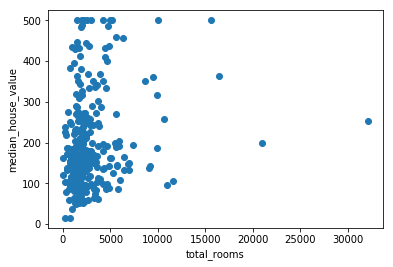

In [8]:
# Plot a scatter plot from our data sample.
plt.scatter(sample["total_rooms"], sample["median_house_value"])

# Label the graph axes.
plt.xlabel("total_rooms")
plt.ylabel("median_house_value")


# Get the min and max total_rooms values.
x_0 = sample["total_rooms"].min()
x_1 = sample["total_rooms"].max()

# Retrieve the final weight and bias generated during training.
weight = linear_regression.get_variable_value('linear/linear_model/total_rooms/weights')[0]
bias = linear_regression.get_variable_value('linear/linear_model/bias_weights')

# Get the predicted median_house_values for the min and max total_rooms values.
y_0 = weight * x_0 + bias 
y_1 = weight * x_1 + bias

# Plot our regression line from (x_0, y_0) to (x_1, y_1).
plt.plot([x_0, x_1], [y_0, y_1], color='orange')
# Display graph.
plt.show()

In [9]:
def train_model(learning_rate, steps, batch_size, input_feature="total_rooms"):
    """Trains a linear regression model of one feature.
  
    Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    input_feature: A `string` specifying a column from `california_housing_dataframe`
      to use as input feature.
    """
  
    periods = 10
    steps_per_period = steps / periods

    feature = input_feature
    feature_data = california_housing_dataframe[[feature]]
    label = "median_house_value"
    target = california_housing_dataframe[label]

    # Create feature columns.
    feature_columns = [tf.feature_column.numeric_column(feature)]
  
    # Create input functions.
    training_input_fn = lambda:input_fn(feature_data, targets, batch_size=batch_size)
    prediction_input_fn = lambda: input_fn(feature_data, targets, n_epochs=1, shuffle=False)
  
    # Create a linear regressor object.
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    linear_regressor = tf.estimator.LinearRegressor(
        feature_columns=feature_columns,
        optimizer=my_optimizer
    )

  # Set up to plot the state of our model's line each period.
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.title("Learned Line by Period")
    plt.ylabel(label)
    plt.xlabel(feature)
    sample = california_housing_dataframe.sample(n=300)
    plt.scatter(sample[feature], sample[label])
    colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]

    # Train the model, but do so inside a loop so that we can periodically assess
    # loss metrics.
    print("Training model...")
    print("RMSE (on training data):")
    root_mean_squared_errors = []
    for period in range (0, periods):
    # Train the model, starting from the prior state.
        linear_regressor.train(
            input_fn=training_input_fn,
            steps=steps_per_period
        )
        # Take a break and compute predictions.
        predictions = linear_regressor.predict(input_fn=prediction_input_fn)
        predictions = np.array([item['predictions'][0] for item in predictions])
    
        # Compute loss.
        root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(predictions, targets))
        # Occasionally print the current loss.
        print("  period %02d : %0.2f" % (period, root_mean_squared_error))
        # Add the loss metrics from this period to our list.
        root_mean_squared_errors.append(root_mean_squared_error)
        # Finally, track the weights and biases over time.
        # Apply some math to ensure that the data and line are plotted neatly.
        y_extents = np.array([0, sample[label].max()])
    
        weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
        bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

        x_extents = (y_extents - bias) / weight
        x_extents = np.maximum(np.minimum(x_extents,
                                          sample[feature].max()), 
                               sample[feature].min())
        y_extents = weight * x_extents + bias
        plt.plot(x_extents, y_extents, color=colors[period]) 
    print("Model training finished.")

    # Output a graph of loss metrics over periods.
    plt.subplot(1, 2, 2)
    plt.ylabel('RMSE')
    plt.xlabel('Periods')
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(root_mean_squared_errors)

    # Output a table with calibration data.
    calibration_data = pd.DataFrame()
    calibration_data["predictions"] = pd.Series(predictions)
    calibration_data["targets"] = pd.Series(targets)
    display.display(calibration_data.describe())

    print("Final RMSE (on training data): %0.2f" % root_mean_squared_error)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Training model...
RMSE (on training data):
  period 00 : 222.75
  period 01 : 209.12
  period 02 : 196.87
  period 03 : 186.29


KeyboardInterrupt: 

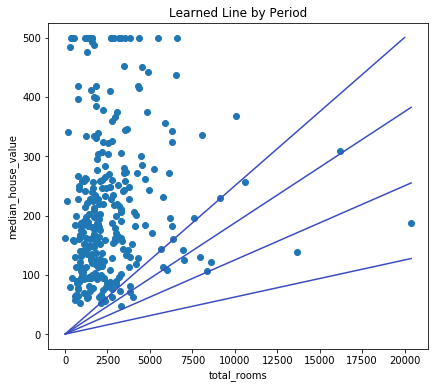

In [10]:
with tf.device('/gpu:0'):# Trains the model and return 'self'

    train_model(
        learning_rate=0.00005,
        steps=250,
        batch_size=80
    )
'''
That said, here are a few rules of thumb that may help guide you:

    - Training error should steadily decrease, steeply at first, and should eventually plateau as training converges.
    - If the training has not converged, try running it for longer.
    - If the training error decreases too slowly, increasing the learning rate may help it decrease faster.
        - But sometimes the exact opposite may happen if the learning rate is too high.
    - If the training error varies wildly, try decreasing the learning rate.
        - Lower learning rate plus larger number of steps or larger batch size is often a good combination.
    - Very small batch sizes can also cause instability. First try larger values like 100 or 1000, and decrease until you see degradation.
'''

'''
train_model(
    learning_rate=0.00002,
    steps=500,
    batch_size=5)
'''

In [ ]:
train_model(
    learning_rate = 0.00005,
    steps = 400,
    batch_size = 50,
    input_feature="population")


''' train_model(
    learning_rate=0.00002,
    steps=1000,
    batch_size=5,
    input_feature="population")
'''